In [2]:
import os
import pandas
import PIL.Image
import PIL.ImageDraw
import torch
import pandas
import xml.etree.ElementTree
import plotnine
import numpy

In [3]:
class dataset:

    def __init__(self, annotation=None, image=None):
        
        self.annotation = annotation
        self.image = image
        count = [len(os.listdir(self.annotation)), len(os.listdir(self.image))]
        assert count[0]==count[1]
        self.length = max(count)
        return

    def get(self, index=0):

        group = {
            'annotation':[a.split('.xml')[0] for a in os.listdir(self.annotation)],
            'image':[i.split('.jpg')[0] for i in os.listdir(self.image)]
        }
        group['set'] = set(group['annotation'] + group['image'])
        group['list'] = sorted(list(group['set']))
        item = group['list'][index]
        path = {
            "annotation":os.path.join(self.annotation, '{}.xml'.format(item)),
            'image':os.path.join(self.image, '{}.jpg'.format(item))
        }
        element = {}
        element['tree'] = xml.etree.ElementTree.parse(path['annotation'])
        element['root'] = element['tree'].getroot()
        element['object'] = element['root'].findall('object')
        element['box'] = [o.find('bndbox') for o in element['object']]
        parse = lambda box: [int(box.find(i).text) for i in ['xmin', 'ymin', 'xmax', 'ymax']]
        element['coordinate'] = [parse(box) for box in element['box']]
        picture = {}
        picture['image'] = PIL.Image.open(path['image'])
        picture['size'] = picture['image'].size
        return(item, picture, element)
    
    def display(self, index=0, show=True, size=None):

        _, picture, element = self.get(index=index)
        paper = PIL.ImageDraw.Draw(picture['image'])
        for c in element['coordinate']:
            
            region = (c[0], c[1]), (c[2], c[3])
            paper.rectangle(region, outline='red', width=5)
            continue

        image = picture['image']
        if(size): image = image.resize(size)
        if(show): image.show()
        return(image)

    pass

In [4]:
annotation = '../resource/acne04-default/xml/'
image = '../resource/acne04-default/jpg/'
dataset = dataset(annotation=annotation, image=image)
dataset.length

1457

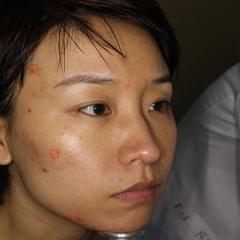

In [5]:
dataset.display(index=1, show=False, size=(240, 240))

In [6]:
collection = {'item':[], 'index':[], 'level':[], 'area':[]}
number = dataset.length
loop = range(number)
for i in loop:

    item, picture, element = dataset.get(index=i)
    level = item.split('_')[0][-1]
    for index, coordinate in enumerate(element['coordinate']):

        compute = lambda coordinate: (coordinate[2]-coordinate[0])*(coordinate[3]-coordinate[1])
        area = compute(coordinate=coordinate)
        collection['item']  += [item]
        collection['index'] += [index]
        collection['level'] += [level]
        collection['area']  += [area]
        continue

    continue

collection = pandas.DataFrame(collection)
collection['log(area)'] = numpy.log(collection['area'])
collection.head()

,item,index,level,area,log(area)
0,level0_0,0,0,448,6.104793
1,level0_0,1,0,572,6.349139
2,level0_0,2,0,506,6.226537
3,level0_1,0,0,12969,9.470317
4,level0_1,1,0,11400,9.341369


In [7]:
storage = './checkpoint/single-acne-area.csv'
os.makedirs(os.path.dirname(storage), exist_ok=True)
collection.to_csv(storage)

In [8]:
group = {}

In [9]:
group['acne area'] = collection.groupby(['level'])['area'].describe().reset_index().copy()
group['acne area'].head()

,level,count,mean,std,min,25%,50%,75%,max
0,0,1043.0,24140.999041,18497.507702,170.0,14409.0,21114.0,29376.0,241081.0
1,1,5548.0,17598.574982,10676.230190,25.0,11316.0,16317.0,22880.0,155210.0
2,2,4663.0,15360.326614,13457.497527,30.0,3783.0,14145.0,21970.0,161396.0
3,3,7729.0,5036.745633,10216.699425,16.0,357.0,992.0,2704.0,177276.0


In [10]:
group['acne log(area)'] = collection.groupby(['level'])['log(area)'].describe().reset_index().copy()
group['acne log(area)'].columns = [
   'level', 'count', 
   'log-mean', 'log-std', 
   'log-min', 'log-25%', 'log-50%', 'log-75%', 'log-max' 
]
group['acne log(area)'].head()

,level,count,log-mean,log-std,log-min,log-25%,log-50%,log-75%,log-max
0,0,1043.0,9.787544,0.996017,5.135798,9.575603,9.957692,10.287933,12.392888
1,1,5548.0,9.462963,1.078759,3.218876,9.333973,9.699961,10.038018,11.952534
2,2,4663.0,8.890713,1.670888,3.401197,8.238273,9.557116,9.997433,11.991616
3,3,7729.0,7.092665,1.668515,2.772589,5.877736,6.899723,7.902487,12.085463


In [11]:
embedding = pandas.merge(group['acne area'], group['acne log(area)'], how='inner', on=['level', 'count'])
embedding.head()

,level,count,mean,std,min,25%,50%,75%,max,log-mean,log-std,log-min,log-25%,log-50%,log-75%,log-max
0,0,1043.0,24140.999041,18497.507702,170.0,14409.0,21114.0,29376.0,241081.0,9.787544,0.996017,5.135798,9.575603,9.957692,10.287933,12.392888
1,1,5548.0,17598.574982,10676.230190,25.0,11316.0,16317.0,22880.0,155210.0,9.462963,1.078759,3.218876,9.333973,9.699961,10.038018,11.952534
2,2,4663.0,15360.326614,13457.497527,30.0,3783.0,14145.0,21970.0,161396.0,8.890713,1.670888,3.401197,8.238273,9.557116,9.997433,11.991616
3,3,7729.0,5036.745633,10216.699425,16.0,357.0,992.0,2704.0,177276.0,7.092665,1.668515,2.772589,5.877736,6.899723,7.902487,12.085463


In [12]:
index = embedding.loc[:, embedding.columns.isin(['level'])].copy()
score = embedding.loc[:, ~embedding.columns.isin(['level', 'count'])].copy()

In [16]:
score = (score - score.mean())/ score.std()
embedding = pandas.concat([index, score], axis=1)
round(embedding, 2).head()

,level,mean,std,min,25%,50%,75%,max,log-mean,log-std,log-min,log-25%,log-50%,log-75%,log-max
0,0,1.09,1.39,1.50,1.07,0.93,0.88,1.46,0.81,-0.98,1.45,0.78,0.65,0.66,1.44
1,1,0.26,-0.67,-0.48,0.59,0.37,0.32,-0.73,0.54,-0.75,-0.40,0.64,0.47,0.43,-0.77
2,2,-0.02,0.06,-0.41,-0.57,0.12,0.24,-0.57,0.07,0.87,-0.22,-0.01,0.37,0.40,-0.57
3,3,-1.32,-0.79,-0.60,-1.09,-1.41,-1.44,-0.16,-1.43,0.86,-0.83,-1.41,-1.49,-1.49,-0.10


In [ ]:
storage = './checkpoint/acne-area-embedding.csv'
os.makedirs(os.path.dirname(storage), exist_ok=True)
embedding.to_csv(storage)

In [ ]:
##  To do: 註解說明